<a href="https://colab.research.google.com/github/freethechicken/pbh_simulations/blob/main/RF3Danalysis_double_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explantions

## 1. **Random Sampling (CPU)**:
The full list of all possible sampling in numpy can be found in the following [link](https://numpy.org/doc/1.16/reference/routines.random.html).
## 2. **GPU computation**:
GPU computation of the random field is given by [Cupy](https://cupy.dev/).

##  3. **Simulation of Gaussian Random Field**

  - Generate the (normal distributed) white noise field $\langle n(\vec x) n(\vec y) \rangle \propto \delta^3(\vec x, \vec y)$.

  - Perform Fast Fourier transform to obtain noise field of unit amplitude $\langle n(\vec k) n(-\vec k) \rangle = 1$

  - Obtain the fourier ampltide by multiplying the white noise field with the
 power spectrum:
$\langle \phi(\vec k)\phi(-\vec k)\rangle'=\langle n(\vec k) n(-\vec k) \rangle \times P(k)$ for $P(k) \equiv {A}{ \lvert k \rvert^{-d}}$.
  - Inverse Fast Fourier transform to obtain the gaussian field.

  - References: Gaussian Random Field is constructed out of [the following website](https://garrettgoon.com/gaussian-fields/).

### **Parameters for Field Simulation:**

- `amplitude`: amplitude of spectrum $A$
- `k_power` : power law of the spectrum $d$
- `pixel` : pixels, size of the plots
- `mean` : mean of the gaussian distribution
- `std_dev` : standard deviation of the gaussian distribution
- `decay_rate` : decay rate of the exponential distribution
- `expected_occurrences_rate ` : expected occurrences rate of the poisson distribution

## 4. **Clustering Algorithm**
### 4.1 **Density-based spatial clustering of applications with noise (DBSCAN)**:
  This algorithm defines clusters as continuous regions of high density.
  - For each instance, the algorithm counts the number of instances within a small distance ϵ (*epsilon*). This region is called the instance’s ϵ-neighborhood.
  - If an instance has at least min_samples instances within its ϵ-neighborhood (includingitself), then it is considered a core instance. Core instances are those that are located in dense regions.
  - All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.
  - Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

### **Parameters**
  - `eps` : distance parameter $ϵ$
  - `min_samples` : Minimum amount of instasnces required in a $ϵ$ neighborhood
  - `Cluster -1` : Instances that are not a core instance. Marked in black color.




In [1]:
# @title Import packages

import numpy as np
#import cupy as cp
import matplotlib.pyplot as plt
import imageio
import os
import gc

from scipy.special import erf
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 1. Define functions

In [3]:
# @title 1.3  Scatter plots

def plot_3d_scatter_field(figs, threshold):
    # Normalize the field values
    normalized_fig = figs / np.abs(figs).max()

    # Create 3D meshgrid
    x, y, z = np.meshgrid(range(exprf.shape[0]),
                          range(exprf.shape[1]),
                          range(exprf.shape[2]))

    # Transparency based on normalized field values
    alphas = 0.5 + 0.5 * (1 - normalized_fig)

    figu = plt.figure(figsize=(6, 6))
    ax = figu.add_subplot(111, projection='3d')

    # Plot scatters above the threshold values
    scatterplts = ax.scatter(x[np.abs(normalized_fig) > threshold],
                            y[np.abs(normalized_fig)  > threshold],
                            z[np.abs(normalized_fig)  > threshold],
                            c=normalized_fig[np.abs(normalized_fig) > threshold],
                            s=5,
                            cmap='viridis')
    #                        alpha=alphas[np.abs(normalized_fig) > threshold])

    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.set_title(f'3D Field Config: (Threshold = { np.abs(figs).max()*threshold:.1f})', fontsize=14)
    figu.colorbar(scatterplts, ax=ax, label='Field Amplitude', shrink=0.5)
    figu.patch.set_facecolor('white')

    plt.show()


def cluster_plt_3D(positions, labels):

    # Apply DBSCAN to the position array
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    for ii in set(labels):
        cluster_index = np.where(labels == ii)[0]
        cluster_positions = positions[cluster_index]

        if ii == -1:
            ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                       s=3, color='black', label='Anomaly')
        else:
            ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                       s=3, label=f'Cluster {ii}')

    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.set_title(f'Clustered 3D field config', fontsize=14)
    #ax.set_xlim(0, pixel)
    #ax.set_ylim(0, pixel)
    #ax.set_zlim(0, pixel)
    plt.legend()
    plt.show()


In [4]:
# @title 1.4 DBSCAN

def cluster_distances(positions,labels):

    # Find unique cluster labels (excluding noise -1)
    unique_labels = set(labels) - {-1}

    # Calculate cluster centers
    cluster_centers = {}
    for ii in set(labels):
        cluster_indices = np.where(labels == ii)[0]
        cluster_positions = positions[cluster_indices]
        cluster_center = np.mean(cluster_positions, axis=0)
        cluster_centers[ii] = cluster_center

    # Calculate distances between cluster centers
    distances = []
    for aa in cluster_centers:
        for bb in cluster_centers:
            if aa != bb & bb > aa:
                distance = euclidean_distances([cluster_centers[aa]], [cluster_centers[bb]])
                distances.append((aa,bb, distance))

    return distances


def cluster_distribution_3d(grf, positions, labels):

    all_cluster_position = {}
    cluster_field_values={}
    for ii in set(labels):
        cluster_indices = np.where(labels == ii)[0]
        all_cluster_position[ii+1] = positions[cluster_indices]
        cluster_field_values[ii+1] = grf[all_cluster_position[ii+1][:,0],
                                         all_cluster_position[ii+1][:,1],
                                         all_cluster_position[ii+1][:,2]]

    for ii in set(labels):
        plt.hist(cluster_field_values[ii+1].flatten(), bins = 100, label=f'Cluster {ii}', alpha=0.3);
        #plt.yscale('log')
        plt.xlabel('Field amplitude')
        plt.ylabel('Number of samples')
        plt.title(f'Cluster Distribution')
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
        plt.grid(True)

    return cluster_field_values

# 2. **Clustering Analysis**

In [5]:
# @title Parameters
# Simulation size from cluster simulations
pixel = 2**8  # 2^8 = 256
z_pixel = pixel # Reduce ram usage

# Cluster parameters
radius = 30
min_samples = 10

In [35]:

# @title Import data from cluster simulations
file_path = '/gdrive/MyDrive/2023 RFSimulations/'
mask_positions = np.load( file_path + 'mask_positions.npy')
exprf = np.load(file_path + 'exponential_field.npy')

In [36]:
dbscan = DBSCAN(eps=radius, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(mask_positions)

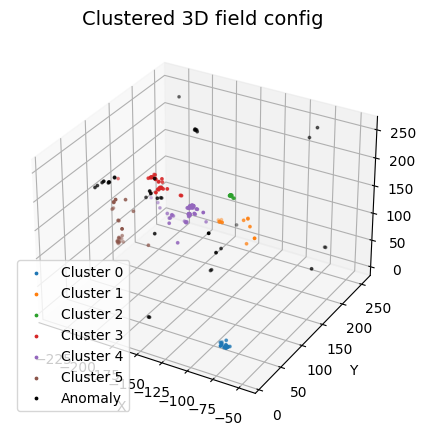

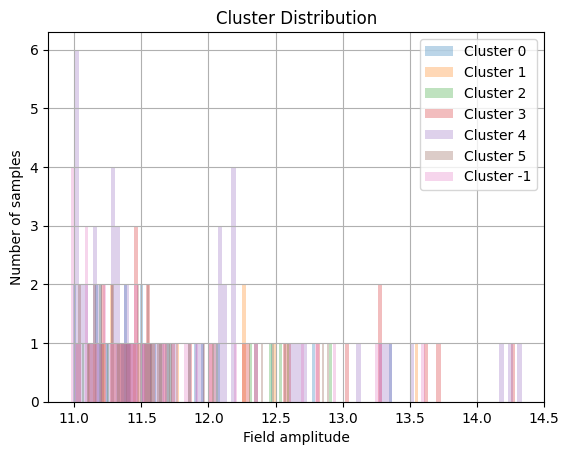

In [49]:
# @title 3D Visualization and Clustering
cluster_plt_3D(mask_positions, cluster_labels)
all_cluster_field_values = cluster_distribution_3d(exprf, mask_positions, cluster_labels)
distances = cluster_distances(mask_positions, cluster_labels)

In [50]:
distances

[(0, 1, array([[169.58163564]])),
 (0, 2, array([[210.56898483]])),
 (0, 3, array([[240.34190853]])),
 (0, 4, array([[195.6681006]])),
 (0, 5, array([[185.29683508]])),
 (1, 2, array([[41.54536473]])),
 (1, 3, array([[100.1963014]])),
 (1, 4, array([[137.80801628]])),
 (1, 5, array([[158.0095366]])),
 (2, 3, array([[78.04292856]])),
 (2, 4, array([[156.18171081]])),
 (2, 5, array([[178.89937757]])),
 (3, 4, array([[194.56828783]])),
 (3, 5, array([[190.86480919]])),
 (4, 5, array([[71.89033505]])),
 (-1, 0, array([[195.66960973]])),
 (-1, 1, array([[75.35691637]])),
 (-1, 2, array([[83.10658206]])),
 (-1, 3, array([[114.66681828]])),
 (-1, 4, array([[80.62623972]])),
 (-1, 5, array([[100.5193386]]))]

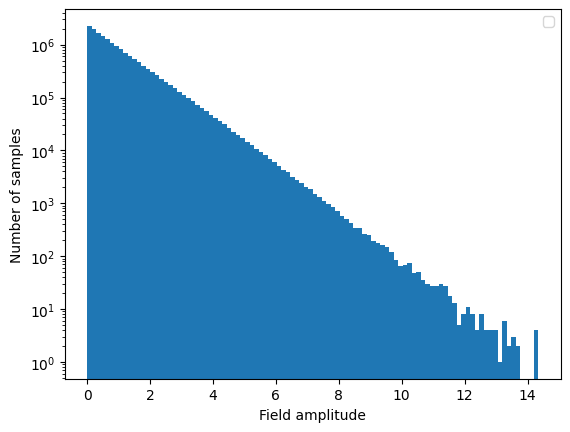

In [31]:
plt.hist(exprf.flatten(),bins=100);
plt.yscale('log')
plt.xlabel('Field amplitude')
plt.ylabel('Number of samples')
plt.legend()

## 2.x 3D Visualization Video (OLD)

In [ ]:
# @title Video for 3D Visualization
# Normalize the field values
ratio = 0.66 # 0.0001
grf = grf / (ratio * np.max(grf))

# Create a list to store individual frames for the GIF
frames = []

# Loop through the third dimension (z-axis) of the grf array
for z in range(grf.shape[2]):
    # Extract 2D slice at the current z-coordinate
    grf_slice = grf[:, :, z]

    # Plot the 2D slice
    plt.imshow(grf_slice, cmap='Blues', clim=[0, 1])
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title(f'Gaussian Random Field (z = {z})')
    # Save the current plot as a frame
    plt.savefig(f'frame_{z:04d}.png')
    plt.close()  # Close the plot for the next iteration

    # Append the saved frame to the frames list
    frames.append(f'frame_{z:04d}.png')

# Create a GIF from the saved frames using imageio
#with imageio.get_writer('grf_animation.gif', mode='I', duration=0.001) as writer:
with imageio.get_writer('grf_animation.mp4', format='FFMPEG', mode='I', fps=30 ) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)
        # Remove the temporary frame files after appending to the GIF
        os.remove(frame)

<ipython-input-10-2ab82a4a7184>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


In [ ]:
# @title Video for 3D Visualization of dense regime
# Normalize the field values
grf_dense = plot_dense_by_ratio_3d(grf,0.33)

grf_dense = grf_dense / (np.max(grf_dense))
# Create a list to store individual frames for the GIF
frames = []

# Loop through the third dimension (z-axis) of the grf array
for z in range(grf_dense.shape[2]):
    # Extract 2D slice at the current z-coordinate
    grf_dense_slice = grf_dense[:, :, z]

    # Plot the 2D slice
    plt.imshow(grf_dense_slice, cmap='rainbow', clim=[-1, 1])
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title(f'Gaussian Random Field (z = {z})')
    # Save the current plot as a frame
    plt.savefig(f'frame_{z:04d}.png')
    plt.close()  # Close the plot for the next iteration

    # Append the saved frame to the frames list
    frames.append(f'frame_{z:04d}.png')

# Create a GIF from the saved frames using imageio
#with imageio.get_writer('grf_animation.gif', mode='I', duration=0.001) as writer:
with imageio.get_writer('od_grf_animation.mp4', format='FFMPEG', mode='I', fps=30 ) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)
        # Remove the temporary frame files after appending to the GIF
        os.remove(frame)

<ipython-input-47-d4c0f2425dd8>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
